# Numerical Methods Final Project
## Simulating Baltimore Policing and Data Fitting | Nicole Pagane | May 2019

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pysal as ps
import re
from geopandas import GeoDataFrame
from shapely.geometry import Point
from pysal.contrib.viz import mapping as maps
import cProfile
import scipy.stats as stats
from datetime import datetime as dt
import time

In [4]:
# read in files
bmore = gpd.read_file("Baltimore2010Tracts.shp") # census data

vc = pd.read_csv("BPD_Part_1_Victim_Based_Crime_Data.csv") # violent crimes

dc = pd.read_csv("BPD_Arrests.csv") # drug crimes

In [5]:
violent_crimes = ["ASSAULT", "LARCENY", "ARSON", "THEFT", "HOMICIDE", "ROBBERY", "RAPE"]
for i in violent_crimes:
    vc[i] = vc['Description'].apply(lambda x: 1 if re.search(i, x, re.IGNORECASE) else 0)

drugCA = np.asarray([])
inds = np.linspace(0, len(dc['ChargeDescription']) - 1, len(dc['ChargeDescription']))
kw = ['CDS', 'HEROIN', 'COCAINE', 'INT', 'PWI']
for i in kw: 
    drugCA = np.unique(np.append(drugCA, inds[(np.asarray(dc['ChargeDescription'].apply(lambda x: 1 if re.search(i, x, re.IGNORECASE) else 0).tolist())) ==1]))

dc['DRUG'] = 0; dc.set_value(drugCA, "DRUG", 1)
dc['BAD'] = 1*(np.asarray(dc['DRUG'] == 1) & np.asarray(dc['Race'] == 'B'))
dc['WAD'] = 1*(np.asarray(dc['DRUG'] == 1) & np.asarray(dc['Race'] == 'W'))
vc['VIOLENT'] = 1*(np.asarray(vc['ASSAULT'] == 1) | np.asarray(vc['HOMICIDE']==1) | np.asarray(vc['ROBBERY']==1) | np.asarray(vc['RAPE']==1))

In [7]:
# make sure that long and lat values are floats
vc_loc = vc.dropna(subset=['Latitude', 'Longitude']) 
vc_loc.loc[:,'Latitude'] = pd.to_numeric(vc_loc['Latitude'], errors = 'coerce')
vc_loc.loc[:,'Longitude'] = pd.to_numeric(vc_loc['Longitude'], errors = 'coerce')
vc_loc = vc_loc.dropna(subset=['Latitude', 'Longitude'])
maxlat = np.max(vc_loc['Latitude']); minlat = np.min(vc_loc['Latitude'])
maxlon = np.max(vc_loc['Longitude']); minlon = np.min(vc_loc['Longitude'])
dc_loc = dc.dropna(subset=['Latitude', 'Longitude']) 
dc_loc.loc[:,'Latitude'] = pd.to_numeric(dc_loc['Latitude'], errors = 'coerce')
dc_loc.loc[:,'Longitude'] = pd.to_numeric(dc_loc['Longitude'], errors = 'coerce')
dc_loc = dc_loc.dropna(subset=['Latitude', 'Longitude']) 

geometry = [Point(xy) for xy in zip(vc_loc.Longitude, vc_loc.Latitude)]
vc_loc = vc_loc.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gvc = GeoDataFrame(vc_loc, crs=crs, geometry=geometry)

geometry = [Point(xy) for xy in zip(dc_loc.Longitude, dc_loc.Latitude)]
dc_loc = dc_loc.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdc = GeoDataFrame(dc_loc, crs=crs, geometry=geometry)

In [8]:
violent_pts = np.zeros(len(bmore))
drug_pts = np.zeros(len(bmore))
bad_pts = np.zeros(len(bmore))
wad_pts = np.zeros(len(bmore))

ind = 0
for poly in bmore.geometry:
    violent_pts[ind] = np.sum(gvc.within(poly) & gvc.VIOLENT)
    d = gdc.within(poly)
    drug_pts[ind] = np.sum(d & gdc.DRUG)
    bad_pts[ind] = np.sum(d & gdc.BAD)
    wad_pts[ind] = np.sum(d & gdc.WAD)
    ind += 1
    if ind % 20 == 0:
        print ind, 'out of ', len(bmore.geometry)
        
print 'done'

20 out of  200
40 out of  200
60 out of  200
80 out of  200
100 out of  200
120 out of  200
140 out of  200
160 out of  200
180 out of  200
200 out of  200
done


In [9]:
bmore['DRUG'] = drug_pts
bmore['VIOLENT'] = violent_pts
bmore['BAD'] = bad_pts
bmore['WAD'] = wad_pts

bmore['BP'] = bmore['blk_afam']/(bmore['blk_afam'] + bmore['white'])
bmore['WP'] = bmore['white']/(bmore['blk_afam'] + bmore['white'])

bmore['PAB'] = bmore['BAD']/bmore['DRUG']
bmore['PAW'] = bmore['WAD']/bmore['DRUG']
bmore['DAB'] = bmore['PAB']/bmore['BP']
bmore['DAW'] = bmore['PAW']/bmore['WP']

show raw drug statistics

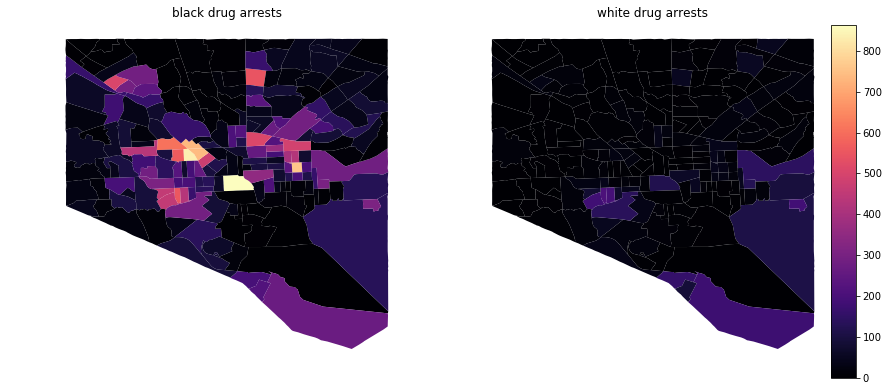

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = 'magma'

vmin = np.min([bmore['WAD'], bmore['BAD']])
vmax = np.max([bmore['WAD'], bmore['BAD']])

p1 = bmore.plot('BAD', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap)
ax1.axis('off')

ax1.set_title('black drug arrests')

p2 = bmore.plot('WAD', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap)
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrests')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap)
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

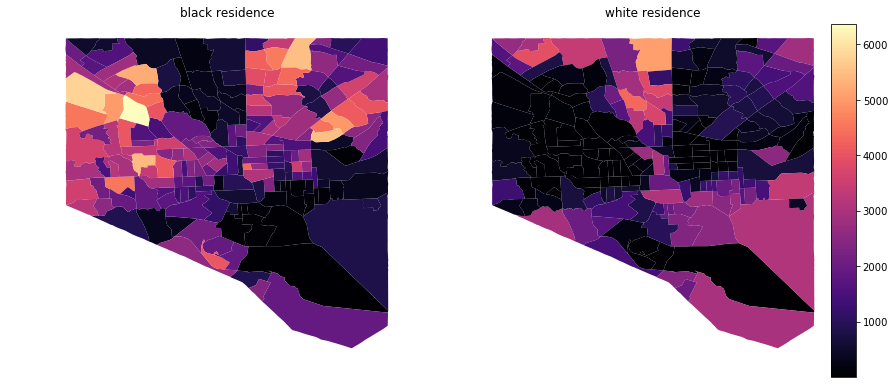

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap

vmin = np.min([bmore['blk_afam'], bmore['white']])
vmax = np.max([bmore['blk_afam'], bmore['white']])

p1 = bmore.plot('blk_afam', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap)
ax1.axis('off')

ax1.set_title('black residence')

p2 = bmore.plot('white', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap)
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white residence')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap)
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

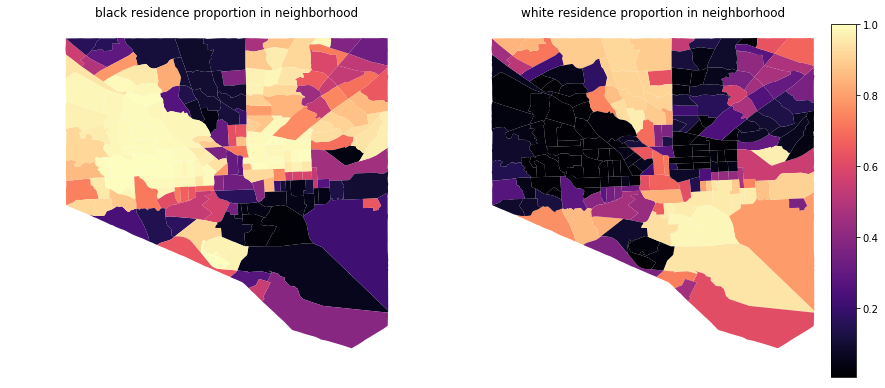

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap

vmin = np.min([bmore['BP'], bmore['WP']])
vmax = np.max([bmore['BP'], bmore['WP']])

p1 = bmore.plot('BP', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap)
ax1.axis('off')

ax1.set_title('black residence proportion in neighborhood')

p2 = bmore.plot('WP', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap)
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white residence proportion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap)
sm._A = [vmin, 1]
fig.colorbar(sm, cax=cax2)


pass

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


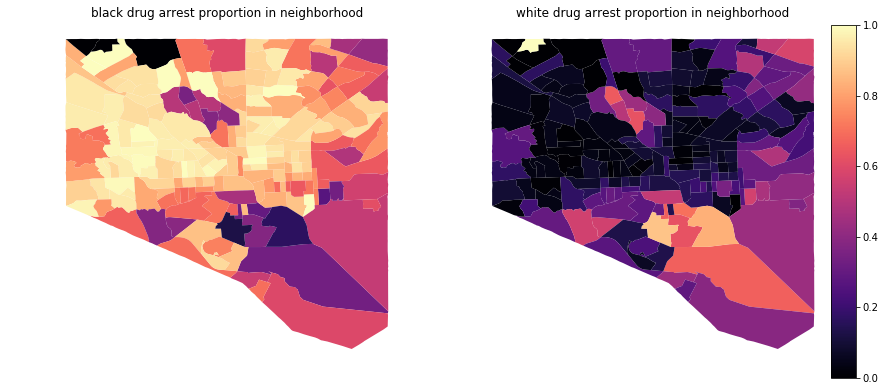

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap

vmin = np.nanmin([bmore['PAB'], bmore['PAW']])
vmax = np.nanmax([bmore['PAB'], bmore['PAW']])

p1 = bmore.plot('PAB', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap)
ax1.axis('off')

ax1.set_title('black drug arrest proportion in neighborhood')

p2 = bmore.plot('PAW', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap)
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrest proportion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap  = cmap)
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

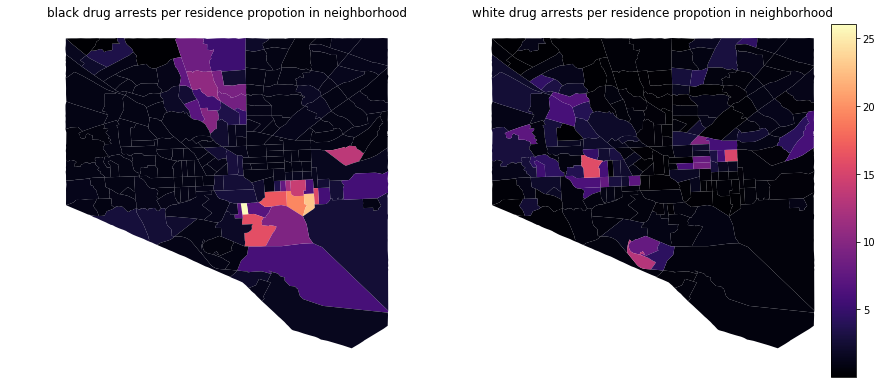

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap

vmin = 1e-3#np.nanmin([bmore['DAB'], bmore['DAW']])
vmax = np.nanmax([bmore['DAB'], bmore['DAW']])

p1 = bmore.plot('DAB', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap)
ax1.axis('off')

ax1.set_title('black drug arrests per residence propotion in neighborhood')

p2 = bmore.plot('DAW', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap)
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrests per residence propotion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap)
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

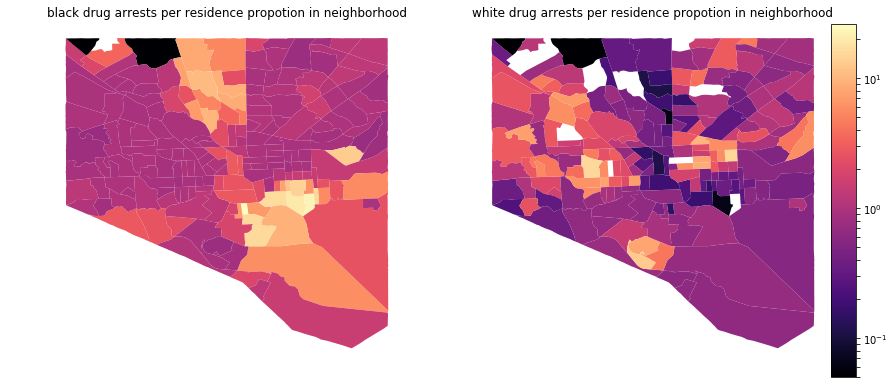

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap

from matplotlib.colors import LogNorm

vmin = 5e-2#np.nanmin([bmore['DAB'], bmore['DAW']])
vmax = np.nanmax([bmore['DAB'], bmore['DAW']])

p1 = bmore.plot('DAB', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax1.axis('off')

ax1.set_title('black drug arrests per residence propotion in neighborhood')

p2 = bmore.plot('DAW', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrests per residence propotion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = LogNorm())
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

In [17]:
strtime = []
for i in range(len(dc_loc)):
    strtime.append(' '.join([dc_loc['ArrestDate'].iloc[i], dc_loc['ArrestTime'].iloc[i]]))
ind = 0
mint = strtime[0]; maxt = strtime[-1]
t = pd.Series(strtime).apply(lambda x: dt.strptime(x, '%m/%d/%Y %H:%M').strftime("%s"))

start 02/28/2019 11:45
stop 01/01/2014 13:00

black arrest rate: 13.593907219141341 per day
white arrest rate: 2.15611646277926 per day

average arrest rate: 7.8750118409603 per day


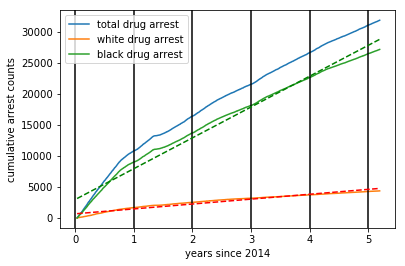

In [56]:
tsort = np.asarray(np.sort(t), dtype = float)
drev = np.cumsum(dc_loc['DRUG'][::-1])
wrev = np.cumsum(dc_loc['WAD'][::-1])
brev = np.cumsum(dc_loc['BAD'][::-1])
Tt = (float(tsort[-1]) - float(tsort[0]))/(3600*24)
print 'start', mint
print 'stop', maxt
print 

offset = 2014-1970
tPlot = tsort/(60*60*24*365) - offset

plt.plot(tPlot, drev, label = 'total drug arrest')
plt.plot(tPlot, wrev, label = 'white drug arrest')
plt.plot(tPlot, brev, label = 'black drug arrest')
for i in range(6):
    plt.axvline(i, color = 'k')
    
# linear regression
b1b = np.sum((brev - np.mean(brev))*(tPlot - np.mean(tPlot)))/(np.sum((tPlot - np.mean(tPlot))**2))
b0b = np.mean(brev) - b1b*np.mean(tPlot)

yhatb = b0b + tPlot*b1b
plt.plot(tPlot, yhatb, 'g--')
print 'black arrest rate:', b1b/365, 'per day'

b1w = np.sum((wrev - np.mean(wrev))*(tPlot - np.mean(tPlot)))/(np.sum((tPlot - np.mean(tPlot))**2))
b0w = np.mean(wrev) - b1w*np.mean(tPlot)

yhatw = b0w + tPlot*b1w
plt.plot(tPlot, yhatw, 'r--')
print 'white arrest rate:', b1w/365, 'per day'

print 
print 'average arrest rate:', (b1w+b1b)/(2.0*365), 'per day'

plt.legend()
plt.xlabel('years since 2014'); plt.ylabel('cumulative arrest counts')

pass

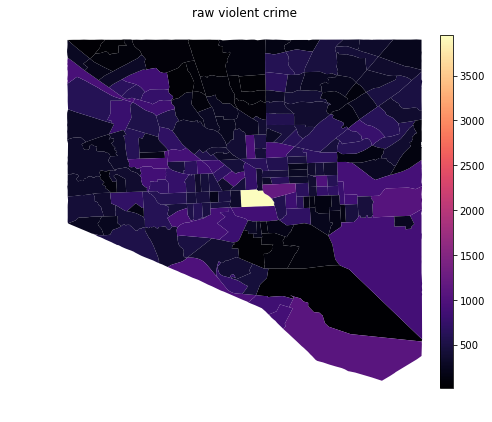

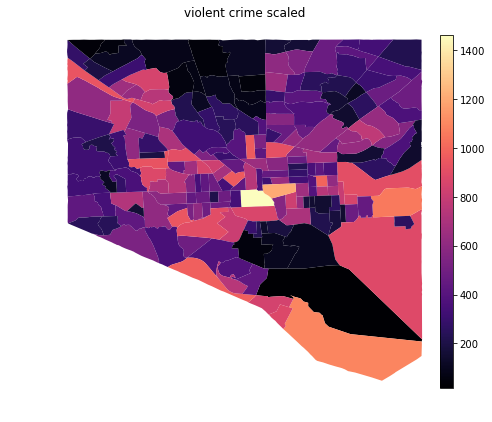

In [52]:
f, ax = plt.subplots(1, figsize=(7, 7))
cmap = cmap

bmore['VS'] = bmore['VIOLENT']
newMax = np.sort(bmore['VIOLENT'])[::-1][1] # second most violent
oldMax = np.argmax(bmore['VIOLENT'])
bmore['VS'].iloc[oldMax] = np.median(bmore['VS']) # temp
bmore['VS'].iloc[oldMax] = newMax + np.std(bmore['VS'])
bmore['VSS'] = bmore['VS']/np.sum(bmore['VS'])

vmin = np.nanmin(bmore['VIOLENT'])
vmax = np.nanmax(bmore['VIOLENT'])

p1 = bmore.plot('VIOLENT', ax=ax, vmin = vmin, vmax = vmax, cmap = cmap)
ax.axis('off')

fig = ax.get_figure()
ax.set_title('raw violent crime')
cax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
sm = plt.cm.ScalarMappable(cmap = cmap)
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax)


vmin = np.nanmin(bmore['VS'])
vmax = np.nanmax(bmore['VS'])

f, ax = plt.subplots(1, figsize=(7, 7))
p2 = bmore.plot('VS', ax = ax, vmin = vmin, vmax = vmax, cmap = cmap)
ax.axis('off')
fig = ax.get_figure()
ax.set_title('violent crime scaled')
cax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
sm = plt.cm.ScalarMappable(cmap = cmap)
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax)


pass

In [82]:
number=2514 # number of BPD cops
bp = bmore['BP']
wp = bmore['WP']
pop = bmore['blk_afam'] + bmore['white']
bpop = np.round(bp*pop)
wpop = np.round(wp*pop)
ideal = np.round(bmore['VS']*number)
nbs = np.repeat(np.linspace(0, len(bmore)-1, len(bmore), dtype = 'int'), ideal.tolist(), axis=0)

def kMC(Tt, params):
    arb = np.zeros(len(bmore))
    arw = np.zeros(len(bmore))
    brate, wrate, bwinb, bwinw = params
    dInd = 1; tt = 0
    while (tt < Tt):
        nb = nbs[np.random.randint(len(nbs))] # sample neighborhood to select from
        aw = wrate*(wp[nb] + bp[nb]*bwinw)
        bw = brate*(wp[nb]*bwinb + bp[nb]) # bw model
        prop = aw + bw
        dt = -np.log(np.random.uniform()) / prop
        tt = tt + dt
        if (np.random.uniform() < aw / prop): # arrest white
            arw[nb] = arw[nb] + 1
        else: # arrest black 
            arb[nb] = arb[nb] + 1
        dInd = dInd + 1
    return np.asarray([arb, arw])

In [87]:
pN = ideal/np.sum(ideal)

def RK(Tt, params):
    brate, wrate, bwinb, bwinw = params
    # define differential policing per neighborhood
    dxdt = np.asarray(
                    [
                    brate*(wp*bwinb + bp)*pN,
                    wrate*(wp + bp*bwinw)*pN
                    ]
                    ).reshape([2,len(bmore)])
    return dxdt*Tt

In [84]:
arbV = []; arwV = []
arbMu = np.zeros(len(bmore))
arwMu = np.zeros(len(bmore))
for i in range(50):
    arb, arw =  kMC(Tt, [7.875, 7.875, 5.5, 0.1])
    arbn = arb/(arb+arw); arwn = arw/(arb+arw)
    arb = arbn/bp; arw = arwn/wp
    arbMu += 1.0*arb/50.0; arwMu += 1.0*arw/50.0
    arbV.append(arb[88]); arwV.append(arw[88])

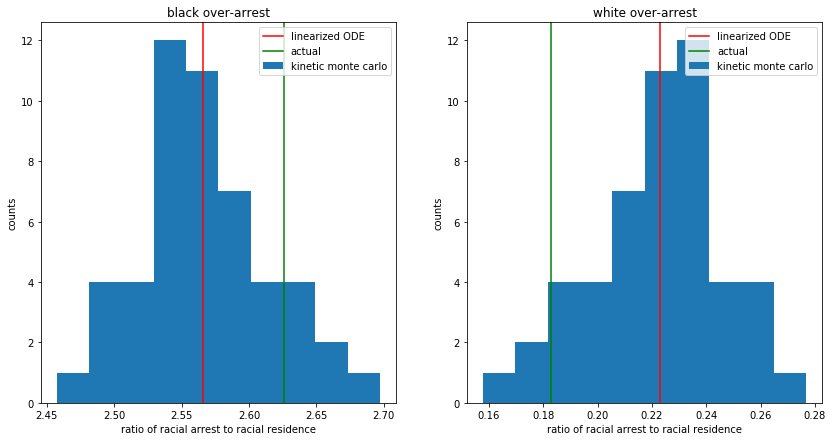

In [92]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

x = RK(Tt, [7.875, 7.875, 5.5, 0.1])

ax1.hist(arbV, bins = 10)
ax1.set_title('black over-arrest')
detb = (x[0,:]/np.sum(x, 0))/bp
ax1.axvline(detb[88], color = 'r')
ax1.axvline(bmore['DAB'][88], color = 'g')
ax1.set_xlabel('ratio of racial arrest to racial residence')
ax1.set_ylabel('counts')
ax1.legend(['linearized ODE', 'actual', 'kinetic monte carlo'])
ax2.hist(arwV, bins = 10)
detw = (x[1,:]/np.sum(x, 0))/wp
ax2.axvline(detw[88], color = 'r')
ax2.axvline(bmore['DAW'][88], color = 'g')
ax2.set_title('white over-arrest')
ax2.set_xlabel('ratio of racial arrest to racial residence')
ax2.set_ylabel('counts')
ax2.legend(['linearized ODE', 'actual', 'kinetic monte carlo'])

plt.show()

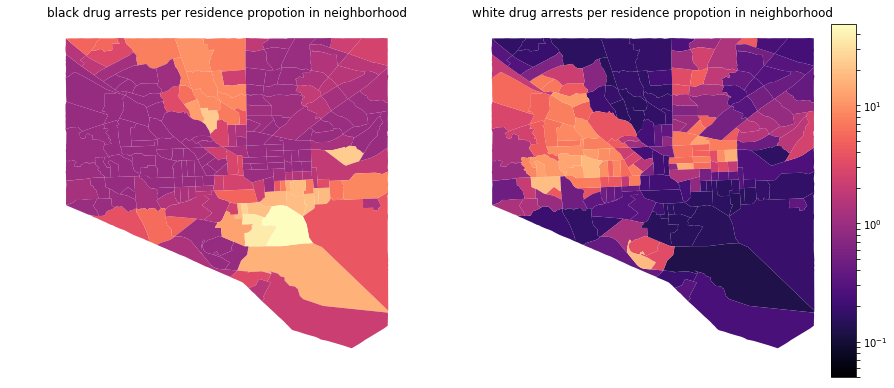

In [95]:
# deterministic
#bmore['B'] = x[0,:]/np.sum(x, 0)
#bmore['W'] = x[1,:]/np.sum(x, 0)
bmore['BB'] = arbMu
bmore['WW'] = arwMu

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap


vmin = 5e-2#np.nanmin([bmore['DAB'], bmore['DAW']])
vmax = np.nanmax([bmore['BB'], bmore['WW']])

p1 = bmore.plot('BB', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax1.axis('off')

ax1.set_title('black drug arrests per residence propotion in neighborhood')

p2 = bmore.plot('WW', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrests per residence propotion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = LogNorm())
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

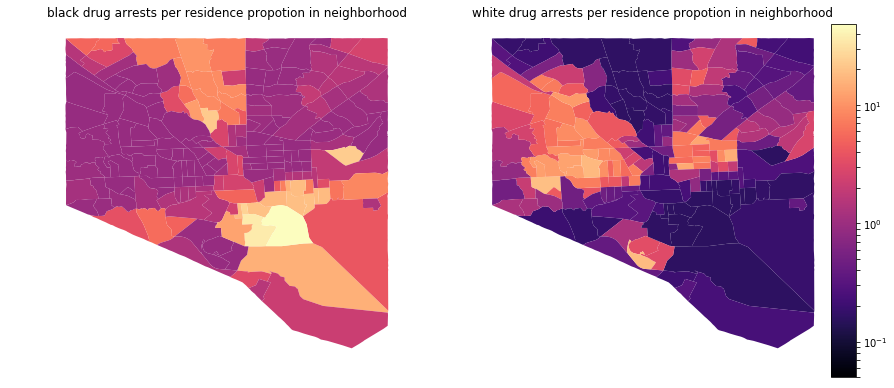

In [96]:
x = RK(Tt, [7.875, 7.875, 5.5, 0.1])

bmore['B'] = x[0,:]/np.sum(x, 0)
bmore['W'] = x[1,:]/np.sum(x, 0)
bmore['BB'] = bmore['B']/bmore['BP']
bmore['WW'] = bmore['W']/bmore['WP']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap


vmin = 5e-2#np.nanmin([bmore['DAB'], bmore['DAW']])
vmax = np.nanmax([bmore['BB'], bmore['WW']])

p1 = bmore.plot('BB', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax1.axis('off')

ax1.set_title('black drug arrests per residence propotion in neighborhood')

p2 = bmore.plot('WW', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrests per residence propotion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = LogNorm())
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass

In [323]:
# MCMC bayesian analysis

# parameters (brate, wrate, bwinb, bwinw )

# proposal q(x)
qSig = np.asarray([7.875, 7.875, 3*np.sqrt(5.5), np.sqrt(0.1)])

# data
bdata = bmore['DAB']
wdata = bmore['DAW']

# initialize for the MCMC
N = int(2e4)
acc = [0, 0]

theta = np.asarray([7.875, 7.875, 5.5, 0.1]) # initial guesses
thetaVec = np.zeros(len(theta)*N).reshape([N, len(theta)])
accVec = np.zeros(2*N).reshape([N, 2])
likVec = np.zeros(N)

# sim
sim =  RK(Tt, theta)
bsim = sim[0,:]/np.sum(sim, 0)
wsim = sim[1,:]/np.sum(sim, 0)
bsim = bsim/bp
wsim = wsim/wp
T0 = 5; T = T0; tau = 5000.0

likelihood = np.sqrt(np.sum((bdata - bsim)**2))*np.sqrt(np.sum((wdata - wsim)**2))

start = time.time()
# start data fitting MCMC via bayes rule
for i in range(N):
    # rotate parameters
    rot =  2 + i % 2
    x = theta[rot]
    # proposal
    theta0 = 1.0*theta[:]
    x0 = stats.norm.rvs(x, qSig[rot])
    theta0[rot] = x0
    # simulate
    sim0 =  RK(Tt, theta0)
    bsim0 = sim0[0,:]/np.sum(sim0, 0)
    wsim0 = sim0[1,:]/np.sum(sim0, 0)
    bsim0 = bsim0/bp
    wsim0 = wsim0/wp
    # assess the proposed new parameter
    likelihood0 = np.sqrt(np.sum((bdata - bsim0)**2))*np.sqrt(np.sum((wdata - wsim0)**2))
    ratio = np.exp(-(likelihood0 - likelihood)/(T*likelihood))
    # M-H criterion
    if np.abs(ratio) > np.random.rand() and np.sum(np.abs(theta0[2:4]) < 50) == 2: 
        # accept
        theta = 1.0*theta0[:]
        # update sim
        sim =  RK(Tt, theta)
        bsim = sim[0,:]/np.sum(sim, 0)
        wsim = sim[1,:]/np.sum(sim, 0)
        bsim = bsim/bp
        wsim = wsim/wp
        # update params
        likelihood = np.sqrt(np.sum((bdata - bsim)**2))*np.sqrt(np.sum((wdata - wsim)**2))
        # increment
        acc[rot-2] += 1
    # cool system
    T = T0*np.exp(-1.0*i/tau)
    accVec[i] = 1.0*np.asarray(acc)/(i+1)
    thetaVec[i] = theta
    likVec[i] = likelihood

stop = time.time()
    
print 'done in', (stop-start)/60.0, 'min'

done in 1.11431853374 min


rejecting first half as burnin, 10000 iterations analyzed


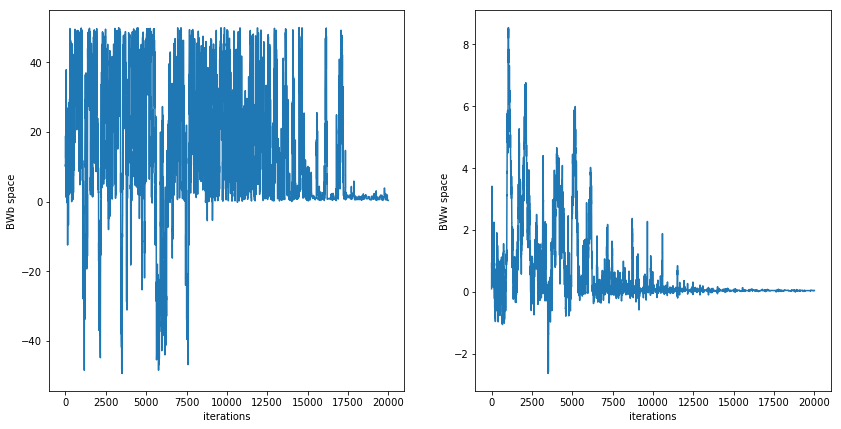

In [330]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.plot(thetaVec[:,2])
ax2.plot(thetaVec[:,3])

print 'rejecting first half as burnin,', int(N/2), 'iterations analyzed'

ax1.set_xlabel('iterations')
ax1.set_ylabel('BWb space')

ax2.set_xlabel('iterations')
ax2.set_ylabel('BWw space')

#plt.legend(['bwinb', 'bwinw'])
plt.show()

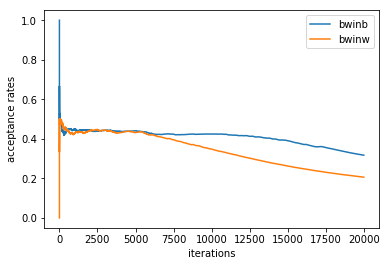

In [326]:
plt.plot(accVec[:])
plt.legend(['bwinb', 'bwinw'])

plt.xlabel('iterations')
plt.ylabel('acceptance rates')


plt.show()

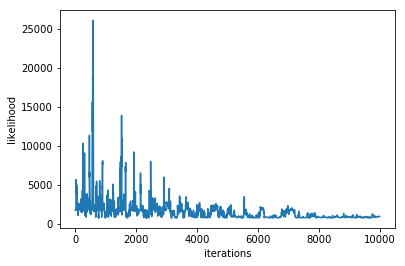

In [327]:
plt.plot(likVec[int(N/2):])

plt.xlabel('iterations')
plt.ylabel('likelihood')


plt.show()

In [328]:
print 'bwb 16th percentile', np.sort(thetaVec[int(N/2):,2])[int(0.16*N/2)]
print 'bwb 50th percentile', np.sort(thetaVec[int(N/2):,2])[int(0.5*N/2)]
print 'bwb 84th percentile', np.sort(thetaVec[int(N/2):,2])[int(0.84*N/2)]
print
print 'bww 16th percentile', np.sort(thetaVec[int(N/2):,3])[int(0.16*N/2)]
print 'bww 50th percentile', np.sort(thetaVec[int(N/2):,3])[int(0.5*N/2)]
print 'bww 84th percentile', np.sort(thetaVec[int(N/2):,3])[int(0.84*N/2)] 

bwb 16th percentile 0.6930923301524157
bwb 50th percentile 1.7956135509506086
bwb 84th percentile 25.3975995370622

bww 16th percentile 0.025835150041165288
bww 50th percentile 0.046800294552967914
bww 84th percentile 0.07641763603044495


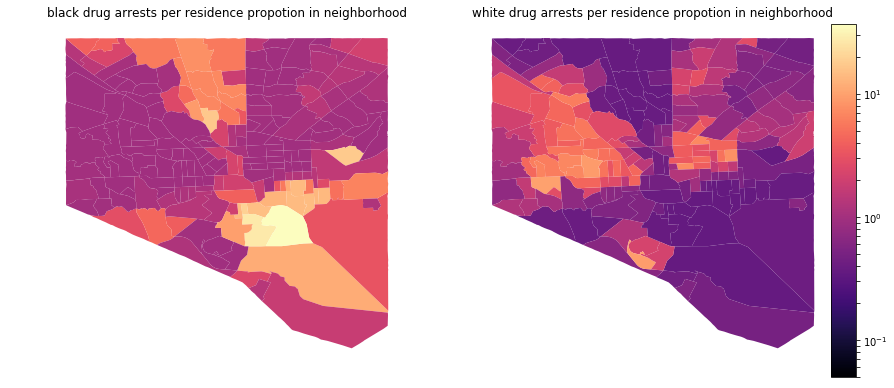

In [329]:
x = RK(Tt, [7.875, 7.875, 1.795, 0.0468])

bmore['B'] = x[0,:]/np.sum(x, 0)
bmore['W'] = x[1,:]/np.sum(x, 0)
bmore['BB'] = bmore['B']/bmore['BP']
bmore['WW'] = bmore['W']/bmore['WP']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
cmap = cmap


vmin = 5e-2#np.nanmin([bmore['DAB'], bmore['DAW']])
vmax = np.nanmax([bmore['BB'], bmore['WW']])

p1 = bmore.plot('BB', ax=ax1, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax1.axis('off')

ax1.set_title('black drug arrests per residence propotion in neighborhood')

p2 = bmore.plot('WW', ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap, norm = LogNorm())
ax2.axis('off')

fig = ax2.get_figure()
ax2.set_title('white drug arrests per residence propotion in neighborhood')
cax2 = fig.add_axes([0.9, 0.32, 0.025, 0.35])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = LogNorm())
sm._A = [vmin, vmax]
fig.colorbar(sm, cax=cax2)


pass